In [2]:
!pip install pennylane numpy scikit-learn tensorflow qiskit qiskit_aer


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import random
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from qiskit.quantum_info import Operator, Statevector
from qiskit import QuantumCircuit
from scipy.linalg import expm
from qiskit_aer import AerSimulator

2025-05-13 15:03:04.242830: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 15:03:06.381529: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-13 15:03:09.614891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747148591.166292    2474 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747148591.216666    2474 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747148594.107603    2474 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [4]:
n_qubits = 5  # 量子比特数
M = 5  # 记忆模式数量（类别）
N = 2 ** n_qubits  # 总状态数
q = 0.2  # 二项分布参数，控制查询状态的汉明距离分布
p_depth = 8  # QAOA电路深度，影响算法精度和计算复杂度
data_mode = 'real'  # 数据模式：'real'使用MNIST，'generated'使用随机模式
steps = 100  # 优化迭代次数，控制参数优化的收敛
# 选择优化器
optimizer_name = "bfgs"  # 可选值："adam", "slsqp", "annealing"

In [5]:
def load_mnist_data(M, n_qubits, n_samples_per_class=50):
    """加载并预处理MNIST数据集"""
    # 加载MNIST数据集
    (x_train, y_train), _ = mnist.load_data()
    # 归一化像素值到[0,1]
    x_train = x_train.astype('float32') / 255.0
    # 重塑为1D向量（28x28=784维）
    x_train = x_train.reshape(-1, 28 * 28)
    
    # 选择前M个类别数据
    selected_classes = np.unique(y_train)[:M]  # 前M个类别
    data, labels = [], []
    for cls in selected_classes:
        # 每个类别选取n_samples_per_class个样本
        idx = np.where(y_train == cls)[0][:n_samples_per_class]
        data.append(x_train[idx])
        labels.append([cls] * len(idx))
    data = np.vstack(data)  # 合并数据 [n_samples, 784]
    labels = np.hstack(labels)  # 合并标签 [n_samples]
    
    # 使用PCA将数据降维与量子比特数匹配
    pca = PCA(n_components=n_qubits) 
    features = pca.fit_transform(data) # [n_samples, n_qubits]
    
    # 二值化特征（基于中位数阈值）
    threshold = np.median(features, axis=0)
    binary_patterns = (features > threshold).astype(int) # [n_samples, n_qubits]
    
    # 为每个类别选择一个代表性模式
    memory_states = []
    pattern_to_class = {}
    for cls in selected_classes:
        cls_idx = np.where(labels == cls)[0]
        cls_features = features[cls_idx]  # 当前类别的降维特征
        cls_binary_patterns = binary_patterns[cls_idx]  # 当前类别的二值化模式
        
        # 使用KMeans聚类选择代表性模式
        kmeans = KMeans(n_clusters=1, random_state=42)  # 每个类别聚为1组
        kmeans.fit(cls_features)
        cluster_center = kmeans.cluster_centers_[0]  # 聚类中心
        
        # 找到最接近聚类中心的样本
        closest_idx = np.argmin(np.linalg.norm(cls_features - cluster_center, axis=1))
        pattern = cls_binary_patterns[closest_idx]  # 选择最接近中心的模式
        
        pattern_str = ''.join(map(str, pattern))  # 转换为二进制字符串
        if pattern_str not in memory_states:
            memory_states.append(pattern_str)
            pattern_to_class[pattern_str] = cls  # 记录模式到类别的映射
    

    # 随机从代表性模式中选择一个作为查询中心
    query_pattern = random.sample(memory_states, 1)[0]
    query_class = pattern_to_class[query_pattern]
    idx_0 = np.where(labels == query_class)[0][0]  # 找到对应的样本索引
    query_image = data[idx_0].reshape(28, 28)  # 重塑为28x28以便可视化

    return memory_states, pattern_to_class, query_pattern, query_class, query_image

def generate_random_patterns(n_qubits, M):
    """生成M个随机的二进制模式"""
    # 生成所有可能模式
    all_patterns = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
    # 随机选择M个唯一模式
    patterns = random.sample(all_patterns, M)
    # 为每个模式分配伪类别标签（0到M-1）
    pattern_to_class = {p: i for i, p in enumerate(patterns)}
    # 随机选择一个查询中心
    query_pattern = random.choice(all_patterns)
    query_class = None
    query_image = None
    return patterns, pattern_to_class, query_pattern, query_class, query_image  



In [ ]:

def format_binary(x):
    """将整数转换为二进制字符串"""
    return format(x, f'0{n_qubits}b')

def hamming_distance(a, b, bin=1):
    if bin != 1:
        a = format_binary(a)
        b = format_binary(b)
    return sum(x != y for x, y in zip(a, b))

def get_distributed_query(query_center, n_qubits, q=0.25):
    """根据二项分布构造分布式查询状态"""
    N = 2 ** n_qubits  # 总状态数
    amplitudes = np.zeros(N)  # 初始化振幅数组
    for x in range(N):
        x_bin = format(x, f'0{n_qubits}b')  # 转换为二进制字符串
        # 计算与查询中心的汉明距离
        hamming_dist = hamming_distance(query_center, x_bin)
        # 根据二项分布设置振幅
        amplitudes[x] = np.sqrt(q ** hamming_dist * (1 - q) ** (n_qubits - hamming_dist))
    # 归一化振幅
    amplitudes /= np.sqrt(np.sum(np.abs(amplitudes) ** 2))
    return amplitudes # 形状为(2^n_qubits,)



# -----------------------
# 构造QAOA算符
# -----------------------
# 实现近似的成本算符 U_C(γ) 和混合算符 U_B(β)

def apply_unitary(qc, gamma, query_state):
    """应用算符 U(γ)"""
    # 应用I+(exp(iγ) - 1)|req><req|
    vector = query_state.reshape(-1, 1)  # 转换为列向量
    # 计算外积
    proj = np.outer(vector, vector.conj())
    H = Operator(proj)  # 创建投影算符
    matrix = expm(1j * gamma * H.data)  # 计算矩阵指数
    qc.unitary(matrix, range(n_qubits), label='U(γ)')
    return qc    



def find_nearest_memory(p, true_memo_ls):
    min_dis = float('inf')
    nearest_memories = []
    # 首先找到最小的汉明距离
    for i in range(len(true_memo_ls)):
        dis =  hamming_distance(p, true_memo_ls[i], bin=1)
        if dis < min_dis:
            min_dis = dis
    
    # 然后收集所有具有最小汉明距离的下标
    print('min_dis:', min_dis)
    for i in range(len(true_memo_ls)):
        dis = hamming_distance(p, true_memo_ls[i], bin=1)
        if dis == min_dis:
            nearest_memories.append(true_memo_ls[i])
    
    return nearest_memories



In [ ]:



# 根据data_mode加载或生成数据
if data_mode == 'real':
    memory_states, pattern_to_class, query_center, center_class, query_image = load_mnist_data(M, n_qubits, n_samples_per_class=50)
    print('MNIST真实数据集')

else:
    memory_states, pattern_to_class, query_center, center_class, query_image = generate_random_patterns(n_qubits, M)
    print('随机生成数据集')


print("记忆模式 memory_states：", memory_states)
print("pattern_to_class：", pattern_to_class)
print("查询中心：", query_center)
print("查询中心类别：", center_class)



# 获取查询状态
query_state = get_distributed_query(query_center, n_qubits, q)
print('查询状态：', query_state)
target = find_nearest_memory(query_center, memory_states)
# 初始记忆态振幅分布
memory_state = np.zeros(2**n_qubits)
for m in memory_states:
    idx = int(m, 2)  # 转换为十进制索引
    memory_state[idx] = 1 / np.sqrt(M)  # 均匀分布
# Global acc
acc_his = []


print('目标态：', target)




# 初始化量子设备
simulator = AerSimulator(method='statevector')  # 使用状态向量模拟器

# 构造QAOA电路
def qaoa_circuit(params, memory_state, query_state, n_qubits, p_depth):
    """构造用于VQAM的QAOA电路"""
    gamma = params[:p_depth]  # 成本算符参数
    beta = params[p_depth:]  # 混合算符参数

    # 初始化量子电路
    qc = QuantumCircuit(n_qubits)

    # 初始化记忆态
    initial_state = np.zeros(2**n_qubits, dtype=complex)
    initial_state[:len(memory_state)] = memory_state
    qc.initialize(initial_state, range(n_qubits))

    # 应用QAOA层
    for k in range(p_depth):
        # 成本算符 U_C(γ)
        apply_unitary(qc, gamma[k], query_state)
        # 混合算符 U_B(β)
        apply_unitary(qc, beta[k], memory_state)

    return qc

def cost_function(params, memory_state, query_state, target, n_qubits, p_depth):
    """计算成本，定义为目标态振幅平方负值，目标态定义为记忆模式中与查询中心最接近的模式"""
    simulator = AerSimulator(method='statevector')
    simulator.set_options(precision='double')
    qc = qaoa_circuit(params, memory_state, query_state, n_qubits, p_depth)
    qc.save_statevector()
    result = simulator.run(qc).result()

    probs = Statevector(result.get_statevector()).probabilities()
    target_amplitudes = sum(probs[int(t, 2)] for t in target)
    

    # 存储当前准确率

    acc=float(target_amplitudes)

    acc_his.append(acc)
    cost = -np.log(acc + 1e-10)  # 加入小值避免log(0)
    print('cost', cost)
    return cost





MNIST真实数据集
记忆模式 memory_states： ['10010', '00110', '11111', '11100', '01001']
pattern_to_class： {'10010': np.uint8(0), '00110': np.uint8(1), '11111': np.uint8(2), '11100': np.uint8(3), '01001': np.uint8(4)}
查询中心： 10010
查询中心类别： 0
查询状态： [0.14310835 0.07155418 0.2862167  0.14310835 0.07155418 0.03577709
 0.14310835 0.07155418 0.07155418 0.03577709 0.14310835 0.07155418
 0.03577709 0.01788854 0.07155418 0.03577709 0.2862167  0.14310835
 0.5724334  0.2862167  0.14310835 0.07155418 0.2862167  0.14310835
 0.14310835 0.07155418 0.2862167  0.14310835 0.07155418 0.03577709
 0.14310835 0.07155418]
min_dis: 0
目标态： ['10010']


In [ ]:


def cost_function_wrapper(params, memory_state, query_state, target, n_qubits, p_depth):
    """包装成本函数，兼容 SciPy"""
    cost = cost_function(params, memory_state, query_state, target, n_qubits, p_depth)
    return float(cost)

def callback_function(params):
    """回调函数，用于动态输出优化过程中的效果"""
    global iteration_count
    iteration_count += 1
    cost = cost_function_wrapper(params, memory_state, query_state, target, n_qubits, p_depth)
    print(f"iter {iteration_count}: cost = {cost:.4f}")

def optimize(optimizer_name, params, memory_state, query_state, target, n_qubits, p_depth, steps):
    """根据用户选择的优化器执行优化"""
    global iteration_count
    iteration_count = 0

    bounds = [(0, np.pi)] * (2 * p_depth)

    if optimizer_name.lower() == "slsqp":
        result = minimize(
            fun=cost_function_wrapper,
            x0=params,
            args=(memory_state, query_state, target, n_qubits, p_depth),
            method="SLSQP",
            bounds=bounds,
            callback=callback_function,
            options={"disp": True, "maxiter": steps}
        )
        return result.x

    elif optimizer_name.lower() == "annealing":
        result = dual_annealing(
            func=cost_function_wrapper,
            bounds=bounds,
            args=(memory_state, query_state, target, n_qubits, p_depth),
            maxiter=steps
        )
        return result.x

    elif optimizer_name.lower() == "bfgs":
        result = minimize(
            fun=cost_function_wrapper,
            x0=params,
            args=(memory_state, query_state, target, n_qubits, p_depth),
            method="L-BFGS-B",
            bounds=bounds,
            callback=callback_function,
            options={"disp": True, "maxiter": steps}
        )
        return result.x

    elif optimizer_name.lower() == "nelder-mead":
        result = minimize(
            fun=cost_function_wrapper,
            x0=params,
            args=(memory_state, query_state, target, n_qubits, p_depth),
            method="Nelder-Mead",
            callback=callback_function,
            options={"disp": True, "maxiter": steps}
        )
        return result.x

    else:
        raise ValueError("不支持的优化器。请选择 'slsqp', 'annealing', 'bfgs' 或 'nelder-mead'。")

# 初始化参数（γ和β），随机分布在[0, π]
params = np.random.uniform(0, np.pi, 2 * p_depth)

# 执行优化
optimal_params = optimize(optimizer_name, params, memory_state, query_state, target, n_qubits, p_depth, steps)

# 计算最终状态
qc = qaoa_circuit(optimal_params, memory_state, query_state, n_qubits, p_depth)
final_probs = Statevector(qc).probabilities()


states = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]  # 所有可能状态

# 打印记忆模式的概率
for state in memory_states:
    idx = int(state, 2)
    cls = pattern_to_class.get(state, 'N/A')
    print(f"state |{state}⟩ (class {cls})：probability = {final_probs[idx]:.4f}")

cost 1.8482590997165111
cost 1.8482591035361238
cost 1.8482590969257167
cost 1.8482590879281209
cost 1.848259089578289
cost 1.8482591002652644
cost 1.8482591082811621
cost 1.8482591082694373


cost 1.8482590946758115
cost 1.8482591053587198
cost 1.8482591092213587
cost 1.8482591085117688
cost 1.84825910730351
cost 1.8482590910216448
cost 1.848259087932564
cost 1.848259099882381
cost 1.848259109434099
cost 1.334453966243531
cost 1.334453970480848
cost 1.334453972356208
cost 1.3344539713980312
cost 1.334453971398033
cost 1.3344539724707258
cost 1.3344539674758324
cost 1.3344539724707267
cost 1.3344539666720356
cost 1.3344539638312503
cost 1.3344539621377065
cost 1.3344539659646182
cost 1.334453963492145
cost 1.3344539717284554
cost 1.334453971728455
cost 1.33445396166458
cost 1.3344539714052484
cost 1.334453966243531
iter 1: cost = 1.3345
cost 1.2019930776140164
cost 1.2019930751856054
cost 1.2019930732321458
cost 1.201993074160751
cost 1.2019930741607516
cost 1.2019930731797586
cost 1.2019930767592373
cost 1.2019930731797597
cost 1.201993079128369
cost 1.201993078915151
cost 1.2019930799301293
cost 1.201993077046249
cost 1.2019930788733846
cost 1.2019930737250195
cost 1.20199

In [28]:
print(AerSimulator().available_methods())

('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop')


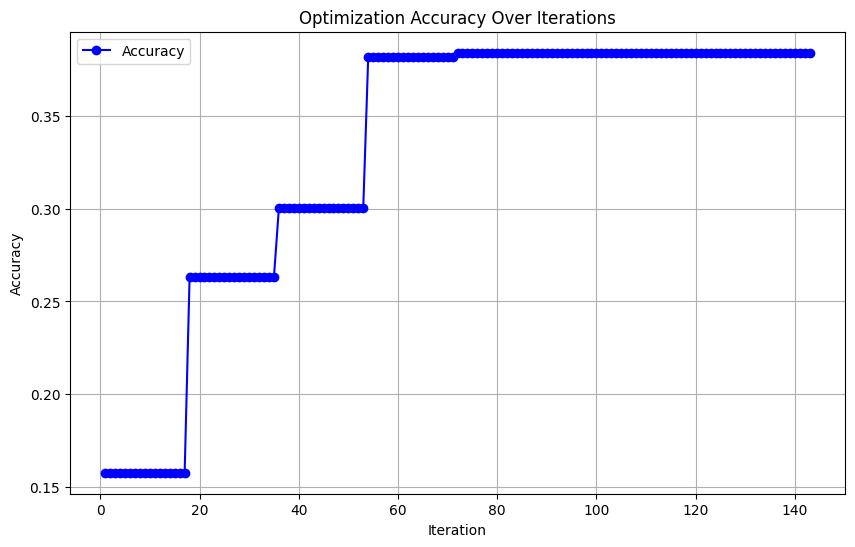

/tmp/ipykernel_2474/2409052308.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


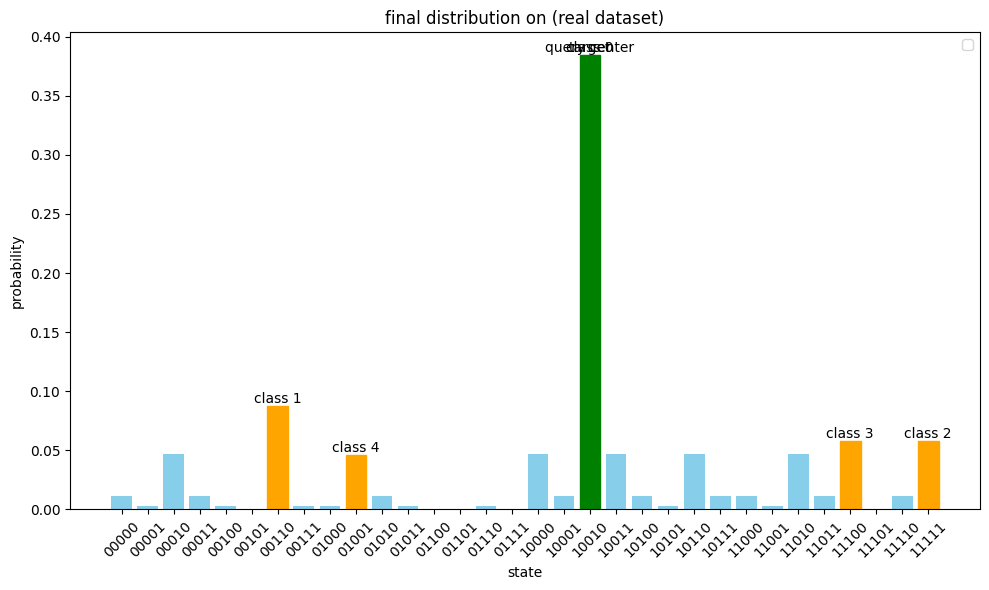

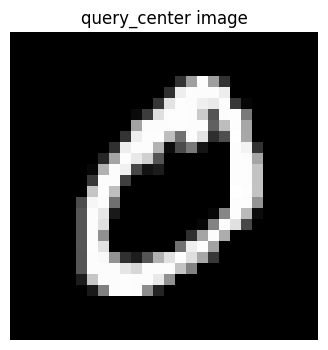

In [29]:
# -----------------------
# 结果可视化
# -----------------------
# 绘制概率分布图，并在MNIST模式下显示查询图像
# 绘制准确率折线图
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(acc_his) + 1), acc_his, marker='o', color='b', label='Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Optimization Accuracy Over Iterations')
plt.legend()
plt.grid()
plt.show()
# 概率分布图
plt.figure(figsize=(10, 6))
bars = plt.bar(states, final_probs, color='skyblue')  # 柱状图
plt.xlabel('state')
plt.ylabel('probability')
plt.title(f'final distribution on ({data_mode} dataset)')
plt.xticks(rotation=45)  # 旋转x轴标签
plt.legend()

# 高亮记忆模式
for i, state in enumerate(states):
    if state in memory_states:
        bars[i].set_color('orange')  
        cls = pattern_to_class.get(state, 'N/A')
        plt.text(i, final_probs[i], f'class {cls}', ha='center', va='bottom')  # 添加类别标签

# 高亮查询中心
center_idx = states.index(query_center)
bars[center_idx].set_color('red')  # 红色高亮查询中心
plt.text(center_idx, final_probs[center_idx], 'query center', ha='center', va='bottom')  # 添加查询中心标签

# 高亮目标态
for t in target:
    target_idx = states.index(t)
    bars[target_idx].set_color('green')  # 绿色高亮目标态
    plt.text(target_idx, final_probs[target_idx], 'target', ha='center', va='bottom')  # 添加目标态标签

plt.tight_layout()
plt.show()

# 查询图像（仅MNIST模式）
if data_mode == 'real' and query_image is not None:
    plt.figure(figsize=(4, 4))
    plt.imshow(query_image, cmap='gray')  # 显示灰度图像
    plt.title('query_center image')
    plt.axis('off')  # 隐藏坐标轴
    plt.show()


4 8


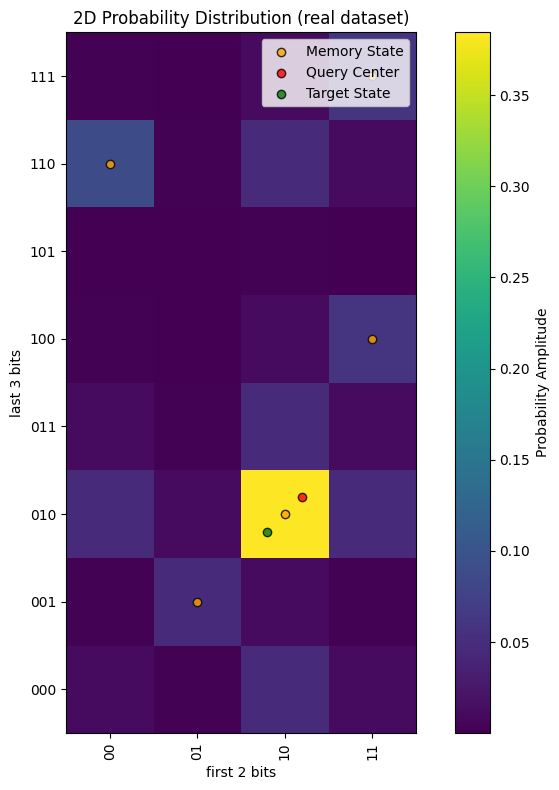

In [30]:
# 将量子态转换为二维坐标
def state_to_coordinates(state, n_qubits):
    """将二进制字符串的量子态转换为二维坐标"""
    x_bits = n_qubits // 2  # x轴的二进制位数
    x = int(state[:x_bits], 2)  # 前x_bits位作为x坐标
    y = int(state[x_bits:], 2)  # 后y_bits位作为y坐标
    return x, y

x_bits = n_qubits // 2 
y_bits = n_qubits - x_bits

# 创建长方形网格
x_size = 2 ** (x_bits)  # x轴大小
y_size = 2 ** (y_bits)  # y轴大小
print(x_size, y_size)
amplitude_grid = np.zeros((x_size, y_size))  # 初始化二维振幅网格

# 填充振幅网格
for i, state in enumerate(states):
    x, y = state_to_coordinates(state, n_qubits)
    if x >= x_size or y >= y_size:
        print(f"Error: Coordinates ({x}, {y}) out of bounds for grid size ({x_size}, {y_size})")
        continue
    amplitude_grid[x, y] = final_probs[i]  # 振幅对应概率

# 绘制二维热力图
plt.figure(figsize=(8, 8))
plt.imshow(amplitude_grid.T, cmap='viridis', origin='lower')  # 使用热力图表示振幅
plt.colorbar(label='Probability Amplitude')  # 添加颜色条
plt.title(f'2D Probability Distribution ({data_mode} dataset)')

# 设置二进制刻度标签
x_labels = [format(i, f'0{x_bits}b') for i in range(x_size)]  # x轴二进制标签
y_labels = [format(i, f'0{y_bits}b') for i in range(y_size)]  # y轴二进制标签
plt.xticks(ticks=range(x_size), labels=x_labels, rotation=90)  # 设置x轴刻度
plt.yticks(ticks=range(y_size), labels=y_labels)  # 设置y轴刻度

plt.xlabel(f'first {x_bits} bits')
plt.ylabel(f'last {y_bits} bits')

# 标出特殊态
offset = 0.2  # 偏移量，用于避免标记重叠

# 绘制记忆态
for state in memory_states:
    x, y = state_to_coordinates(state, n_qubits)
    plt.scatter(x, y, color='orange', label='Memory State', edgecolors='black', alpha=0.8)

# 绘制查询中心
x, y = state_to_coordinates(query_center, n_qubits)
plt.scatter(x + offset, y + offset, color='red', label='Query Center', edgecolors='black', alpha=0.8)  # 偏移标记

# 绘制目标态
for t in target:
    x, y = state_to_coordinates(t, n_qubits)
    plt.scatter(x - offset, y - offset, color='green', label='Target State', edgecolors='black', alpha=0.8)  # 偏移标记

# 添加图例
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # 去重
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of the following families were found: WenQuanYi Zen Hei
findfont: Generic family 'sans-serif' not found because none of 

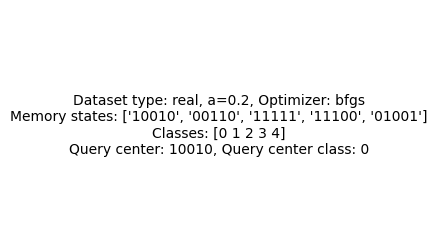

In [34]:

class_array = np.array(list(pattern_to_class.values()), dtype=np.int8)
plt.figure(figsize=(4, 3))
info = f'Dataset type: {data_mode}, a={q}, Optimizer: {optimizer_name}\nMemory states: {memory_states}\nClasses: {class_array}\nQuery center: {query_center}, Query center class: {center_class}'
plt.text(0.5, 0.5, info, ha='center', va='center')
plt.axis('off')
plt.show()
